In [8]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
from pymongo import MongoClient
import scipy
from scipy.integrate import simps
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import loguniform
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, accuracy_score

In [30]:
df = pd.read_csv('/Users/rampageyao/Desktop/tum/applied machine intelligence/project/elec_forecast.csv')

df.head()

,Date,Time of day,Biomass[MWh],Hydropower[MWh],Wind offshore[MWh],Wind onshore[MWh],Photovoltaics[MWh],Other renewable[MWh],Nuclear[MWh],Fossil brown coal[MWh],...,Residual load[MWh],Lufttemp.+200cm,Lufttemp.+20cm,Bodentemp.-5cm,Bodentemp.-20cm,Luftfeuchtigkeit+200cm,Windgeschw.+250cm,Niederschlag,Globalstrahlg.+200cm,Spot price
0,2015/1/1,0,1006.25,289.75,129.25,2032.00,0.0,33.00,2677.75,3922.00,...,1380.75,2.9,2.0,3.1,3.4,100.0,1.5,0.0,39.0,25.02
1,2015/1/1,1,995.75,297.00,129.00,2074.25,0.0,30.75,2771.50,3830.75,...,1229.75,2.9,2.0,3.1,3.4,100.0,1.5,0.0,39.0,18.29
2,2015/1/1,2,1005.00,284.75,128.50,2135.25,0.0,23.50,2756.50,3704.50,...,1126.25,2.9,2.0,3.1,3.4,100.0,1.5,0.0,39.0,16.04
3,2015/1/1,3,1010.50,280.50,129.75,2138.25,0.0,22.00,2757.00,3518.75,...,1141.00,2.9,2.0,3.1,3.4,100.0,1.5,0.0,39.0,14.60
4,2015/1/1,4,1009.75,278.00,130.00,2161.00,0.0,22.00,2740.75,3529.00,...,1170.25,2.9,2.0,3.1,3.4,100.0,1.5,0.0,39.0,14.95


In [31]:
df = df.fillna(df.mean())

**The features that are highly correlated to the label "spot price" in decreasing order:**

**"Fossil gas[MWh]", "Residual load[MWh]", "Fossil hard coal[MWh]", "Total[MWh]", "Fossil brown coal[MWh]", "Wind onshore[MWh]", "Date", "Time of day"**




In [32]:
df = df[["Fossil gas[MWh]", "Residual load[MWh]", "Fossil hard coal[MWh]", "Total[MWh]", "Fossil brown coal[MWh]", "Wind onshore[MWh]", "Date", "Time of day", 'Spot price']]
df.head()

,Fossil gas[MWh],Residual load[MWh],Fossil hard coal[MWh],Total[MWh],Fossil brown coal[MWh],Wind onshore[MWh],Date,Time of day,Spot price
0,306.50,1380.75,805.0,2303.00,3922.00,2032.00,2015/1/1,0,25.02
1,217.75,1229.75,588.0,2245.50,3830.75,2074.25,2015/1/1,1,18.29
2,202.25,1126.25,557.0,2195.75,3704.50,2135.25,2015/1/1,2,16.04
3,205.25,1141.00,585.0,2151.50,3518.75,2138.25,2015/1/1,3,14.60
4,207.75,1170.25,615.5,2134.25,3529.00,2161.00,2015/1/1,4,14.95


**"Windonshore" is highly correlated to "Residual load[MWh] " and "Fossil hard coal[MWh]". Also, "Windonshore" is not that highly correlated to the label. Therefore, drop "Windonshore".**

In [33]:
df.drop(columns=["Wind onshore[MWh]"],inplace=True)
df.head()

,Fossil gas[MWh],Residual load[MWh],Fossil hard coal[MWh],Total[MWh],Fossil brown coal[MWh],Date,Time of day,Spot price
0,306.50,1380.75,805.0,2303.00,3922.00,2015/1/1,0,25.02
1,217.75,1229.75,588.0,2245.50,3830.75,2015/1/1,1,18.29
2,202.25,1126.25,557.0,2195.75,3704.50,2015/1/1,2,16.04
3,205.25,1141.00,585.0,2151.50,3518.75,2015/1/1,3,14.60
4,207.75,1170.25,615.5,2134.25,3529.00,2015/1/1,4,14.95


In [34]:
temp = df['Date'].values.tolist()
index_split_train_test = []
for i in range(len(temp)):
    if temp[i] == '2016/1/4':
        index_split_train_test.append(i)
print(index_split_train_test[len(index_split_train_test)-1]) 

#2021/6/1 23h: 56219
#2021/5/23 23h: 56003
#2021/3/1 23h: 54035
#2016/1/1 23h: 8781 
#2015/12/31 23h: 8757
#2016/1/4 23h: 8853

8853


In [35]:
df.set_index("Date", drop=False, inplace=True)
df.head()

,Fossil gas[MWh],Residual load[MWh],Fossil hard coal[MWh],Total[MWh],Fossil brown coal[MWh],Date,Time of day,Spot price
Date,,,,,,,,
2015/1/1,306.50,1380.75,805.0,2303.00,3922.00,2015/1/1,0,25.02
2015/1/1,217.75,1229.75,588.0,2245.50,3830.75,2015/1/1,1,18.29
2015/1/1,202.25,1126.25,557.0,2195.75,3704.50,2015/1/1,2,16.04
2015/1/1,205.25,1141.00,585.0,2151.50,3518.75,2015/1/1,3,14.60
2015/1/1,207.75,1170.25,615.5,2134.25,3529.00,2015/1/1,4,14.95


In [36]:
df.reset_index(drop=True, inplace=True)
lag_features = ["Fossil gas[MWh]",	"Residual load[MWh]",	"Fossil hard coal[MWh]",	"Total[MWh]",	"Fossil brown coal[MWh]"]
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

df.fillna(df.mean(), inplace=True)

df.set_index("Date", drop=False, inplace=True)
df.head()

,Fossil gas[MWh],Residual load[MWh],Fossil hard coal[MWh],Total[MWh],Fossil brown coal[MWh],Date,Time of day,Spot price,Fossil gas[MWh]_mean_lag3,Fossil gas[MWh]_mean_lag7,...,Total[MWh]_mean_lag30,Total[MWh]_std_lag3,Total[MWh]_std_lag7,Total[MWh]_std_lag30,Fossil brown coal[MWh]_mean_lag3,Fossil brown coal[MWh]_mean_lag7,Fossil brown coal[MWh]_mean_lag30,Fossil brown coal[MWh]_std_lag3,Fossil brown coal[MWh]_std_lag7,Fossil brown coal[MWh]_std_lag30
Date,,,,,,,,,,,,,,,,,,,,,
2015/1/1,306.50,1380.75,805.0,2303.00,3922.00,2015/1/1,0,25.02,1099.559448,1099.515381,...,2945.227783,100.761650,195.668289,360.424835,3318.607666,3318.656738,3318.839600,65.439659,124.516685,253.893524
2015/1/1,217.75,1229.75,588.0,2245.50,3830.75,2015/1/1,1,18.29,306.500000,306.500000,...,2303.000000,100.761650,195.668289,360.424835,3922.000000,3922.000000,3922.000000,65.439659,124.516685,253.893524
2015/1/1,202.25,1126.25,557.0,2195.75,3704.50,2015/1/1,2,16.04,262.125000,262.125000,...,2274.250000,40.658642,40.658642,40.658642,3876.375000,3876.375000,3876.375000,64.523491,64.523491,64.523491
2015/1/1,205.25,1141.00,585.0,2151.50,3518.75,2015/1/1,3,14.60,242.166672,242.166672,...,2248.083252,53.671650,53.671650,53.671650,3819.083252,3819.083252,3819.083252,109.218338,109.218338,109.218338
2015/1/1,207.75,1170.25,615.5,2134.25,3529.00,2015/1/1,4,14.95,208.416672,232.937500,...,2223.937500,47.026810,65.211319,65.211319,3684.666748,3744.000000,3744.000000,156.942734,174.649536,174.649536


In [37]:
df.Date = pd.to_datetime(df.Date, format="%Y-%m-%d")
df["month"] = df.Date.dt.month
df["week"] = df.Date.dt.week
df["day"] = df.Date.dt.day
df["day_of_week"] = df.Date.dt.dayofweek
df.head()

<ipython-input-37-aaf895c467cb>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df["week"] = df.Date.dt.week


,Fossil gas[MWh],Residual load[MWh],Fossil hard coal[MWh],Total[MWh],Fossil brown coal[MWh],Date,Time of day,Spot price,Fossil gas[MWh]_mean_lag3,Fossil gas[MWh]_mean_lag7,...,Fossil brown coal[MWh]_mean_lag3,Fossil brown coal[MWh]_mean_lag7,Fossil brown coal[MWh]_mean_lag30,Fossil brown coal[MWh]_std_lag3,Fossil brown coal[MWh]_std_lag7,Fossil brown coal[MWh]_std_lag30,month,week,day,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2015/1/1,306.50,1380.75,805.0,2303.00,3922.00,2015-01-01,0,25.02,1099.559448,1099.515381,...,3318.607666,3318.656738,3318.839600,65.439659,124.516685,253.893524,1,1,1,3
2015/1/1,217.75,1229.75,588.0,2245.50,3830.75,2015-01-01,1,18.29,306.500000,306.500000,...,3922.000000,3922.000000,3922.000000,65.439659,124.516685,253.893524,1,1,1,3
2015/1/1,202.25,1126.25,557.0,2195.75,3704.50,2015-01-01,2,16.04,262.125000,262.125000,...,3876.375000,3876.375000,3876.375000,64.523491,64.523491,64.523491,1,1,1,3
2015/1/1,205.25,1141.00,585.0,2151.50,3518.75,2015-01-01,3,14.60,242.166672,242.166672,...,3819.083252,3819.083252,3819.083252,109.218338,109.218338,109.218338,1,1,1,3
2015/1/1,207.75,1170.25,615.5,2134.25,3529.00,2015-01-01,4,14.95,208.416672,232.937500,...,3684.666748,3744.000000,3744.000000,156.942734,174.649536,174.649536,1,1,1,3


In [38]:
df_train = df[:9500]

df_valid = df[9500:9600]

In [39]:
print(len(df_train))
print(len(df_valid))

9500
100


In [40]:
exogenous_features = ["Fossil gas[MWh]_mean_lag3", "Fossil gas[MWh]_mean_lag7", "Fossil gas[MWh]_mean_lag30", "Fossil gas[MWh]_std_lag3", "Fossil gas[MWh]_std_lag7", "Fossil gas[MWh]_std_lag30", 
                      "Residual load[MWh]_mean_lag3", "Residual load[MWh]_mean_lag7", "Residual load[MWh]_mean_lag30", "Residual load[MWh]_std_lag3", "Residual load[MWh]_std_lag7", "Residual load[MWh]_std_lag30",
                      "Fossil hard coal[MWh]_mean_lag3", "Fossil hard coal[MWh]_mean_lag7", "Fossil hard coal[MWh]_mean_lag30", "Fossil hard coal[MWh]_std_lag3", "Fossil hard coal[MWh]_std_lag7", "Fossil hard coal[MWh]_std_lag30",
                      "Total[MWh]_mean_lag3", "Total[MWh]_mean_lag7", "Total[MWh]_mean_lag30", "Total[MWh]_std_lag3", "Total[MWh]_std_lag7", "Total[MWh]_std_lag30",
                      "Fossil brown coal[MWh]_mean_lag3", "Fossil brown coal[MWh]_mean_lag7", "Fossil brown coal[MWh]_mean_lag30", "Fossil brown coal[MWh]_std_lag3", "Fossil brown coal[MWh]_std_lag7", "Fossil brown coal[MWh]_std_lag30",
                      ]

In [41]:
model = auto_arima(df_train['Spot price'], exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train['Spot price'], exogenous=df_train[exogenous_features])

evidence = model.predict(n_periods=len(df_train), exogenous=df_train[exogenous_features])
df_train["Train_ARIMAX"] = evidence

forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=51933.253, Time=29.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=52755.932, Time=7.73 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=52538.860, Time=25.44 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=52489.570, Time=25.60 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=52969.182, Time=30.35 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=51820.506, Time=28.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=52453.285, Time=26.52 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=52521.972, Time=27.32 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=51544.006, Time=33.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=51920.333, Time=29.00 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=51609.011, Time=33.58 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=51453.470, Time=33.51 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=51684.516, Time=33.65 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=51539.473, Time=33.47 sec
 ARIMA

/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
<ipython-input-41-fe6f0dd327a3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["Train_ARIMAX"] = evidence
/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
<ipython-input-41-fe6f0dd327a3>:8: SettingWithCopyWarning: 
A value is trying to be set on 

In [42]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid['Spot price'], df_valid.Forecast_ARIMAX)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid['Spot price'], df_valid.Forecast_ARIMAX))

RMSE of Auto ARIMAX: 4.6711071888693905

MAE of Auto ARIMAX: 3.6736720303931487


In [43]:
y = df_valid["Forecast_ARIMAX"].tolist()
#print(len(y))

#print(df[df.Date > "2015/12/31"].iloc[:,5])
#x = df[df.Date > "2015/12/31"].iloc[:,5]
x = list(range(0,len(y)))
#print(x)

Text(0.5, 1.0, 'Forecast')

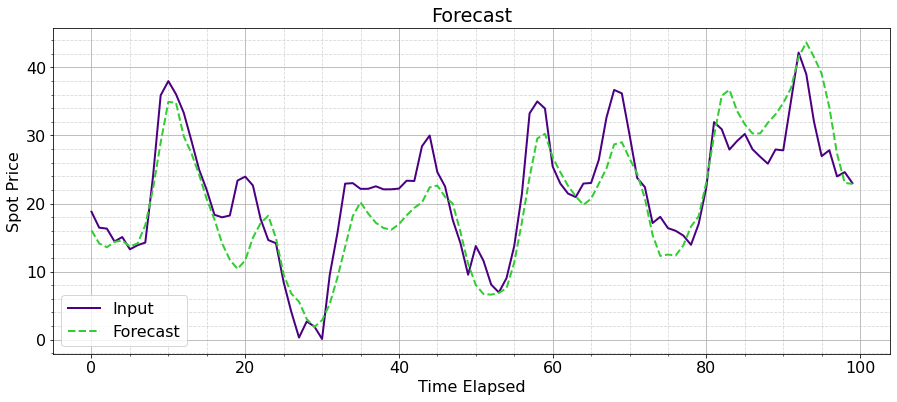

In [44]:
plt.figure(figsize=(15,6))
plt.rcParams.update({"font.size" : 16})

plt.plot(x, df_valid["Spot price"], '-', color = 'indigo', label = 'Input', linewidth=2)
plt.plot(x, df_valid["Forecast_ARIMAX"],'--', color = 'limegreen', label = 'Forecast', linewidth=2)

#formatting
plt.grid(b=True, which='major', linestyle = 'solid')
plt.minorticks_on()
plt.grid(b=True, which='minor', linestyle = 'dashed', alpha=0.5)
plt.xlabel("Time Elapsed")
plt.ylabel("Spot Price")
plt.legend()
plt.title("Forecast")